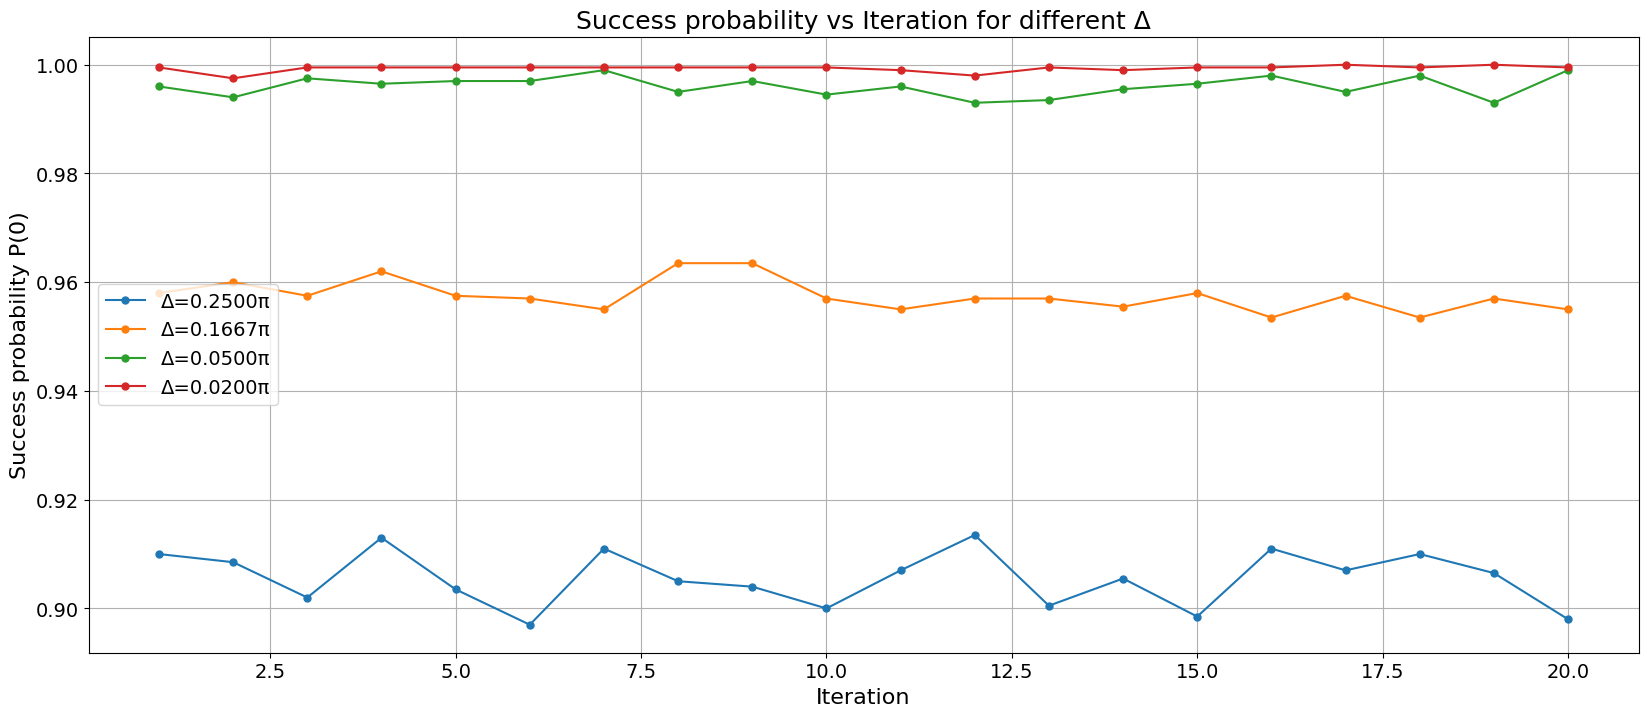

In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.result import marginal_counts
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Parameters ----------------
psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 2, 3, 4, 5, 6, 7, 8]
n = 3          # number of qubits per register
m = 20         # number of iterations
number_of_layers = 2
shots = 2000

# Pick 4 fixed δ values (as multiples of π)
delta_fractions = [1/4, 1/6, 1/20, 1/50]   # π/4, π/6, π/20, π/50
deltas = [f * np.pi for f in delta_fractions]

# Build MPS initializers
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()

sim = AerSimulator()
success_probs_dict = {}

# ---------------- Function to run one experiment ----------------
def run_experiment(delta):
    psi_reg = QuantumRegister(n, name="ψ")
    phi_reg = QuantumRegister(n, name="φ")
    cregs = [ClassicalRegister(n, name=f"c{k}") for k in range(m)]
    qc = QuantumCircuit(psi_reg, phi_reg, *cregs)

    # Initialize ψ and φ
    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for k in range(m):
        # bit matching
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

        # controlled phase
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])

        # undo matching
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        # measure φ
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, cregs[k])
        qc.reset(phi_reg)

        if k < m-1:
            qc.append(U_phi, phi_reg)

    qc.save_statevector()
    qc_t = transpile(qc.decompose(reps=10), sim, optimization_level=0)
    result = sim.run(qc_t, shots=shots).result()

    # Collect per-iteration success probabilities
    success_probs = []
    for k in range(m):
        indices = list(range(k*n, (k+1)*n))  # clbits for c[k]
        counts_k = marginal_counts(result.get_counts(qc_t), indices)
        zero_state = "0"*n
        success_probs.append(counts_k.get(zero_state, 0) / shots)
    return success_probs

# ---------------- Run experiments for each δ ----------------
for delta in deltas:
    success_probs_dict[delta] = run_experiment(delta)

# ---------------- Plotting ----------------
plt.figure(figsize=(20, 8))
for delta in deltas:
    sim_probs = success_probs_dict[delta]
    plt.plot(range(1, m+1), sim_probs, marker='o', linestyle='-', markersize=5,
             label=f"Δ={delta/np.pi:.4f}π")

plt.xlabel("Iteration", fontsize=16)
plt.ylabel("Success probability P(0)", fontsize=16)
plt.title("Success probability vs Iteration for different Δ", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()


In [ ]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.result import marginal_counts
import numpy as np
import matplotlib.pyplot as plt

#  Parameters
psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 2, 3, 4, 5, 6, 7, 8]
n = 3           # number of qubits for ψ and φ
number_of_layers = 2
shots = 2000



#Build MPS initializers
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()

#Function to run one experiment
def run_experiment(delta, m, shots=2000):
    psi_reg = QuantumRegister(n, "ψ")
    phi_reg = QuantumRegister(n, "φ")
    cregs = [ClassicalRegister(n, name=f"c{k}") for k in range(m)]
    qc = QuantumCircuit(psi_reg, phi_reg, *cregs)

    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for k in range(m):
        # matching
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)
        # controlled phase
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])
        # unmatch
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, cregs[k])
        qc.reset(phi_reg)
        if k < m - 1:
            qc.append(U_phi, phi_reg)
    
    return qc



In [ ]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.result import marginal_counts
import numpy as np
import matplotlib.pyplot as plt

#  Parameters
psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 2, 3, 4, 5, 6, 7, 8]
n = 3           # number of qubits for ψ and φ
number_of_layers = 2
shots = 2000



#Build MPS initializers
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()

#Function to run one experiment
def run_experiment(delta, m, shots=2000):
    psi_reg = QuantumRegister(n, "ψ")
    phi_reg = QuantumRegister(n, "φ")
    cregs = [ClassicalRegister(n, name=f"c{k}") for k in range(m)]
    qc = QuantumCircuit(psi_reg, phi_reg, *cregs)

    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for k in range(m):
        # matching
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)
        # controlled phase
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])
        # unmatch
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, cregs[k])
        qc.reset(phi_reg)
        if k < m - 1:
            qc.append(U_phi, phi_reg)
    
    return qc



In [4]:
def success_rates(delta, m, shots=200):
    qc = run_experiment(delta, m)
    sim = AerSimulator()
    qc_t = transpile(qc, sim)

    result = sim.run(qc_t, shots=shots, memory=True).result()
    memories = result.get_memory(qc_t)

    zero_state = "0" * n

    successes = 0
    for mem in memories:

        parts = mem.split(" ") 

        if all(r == zero_state for r in parts):
            successes += 1

    success_fraction = successes / shots
    

    return success_fraction, memories, qc


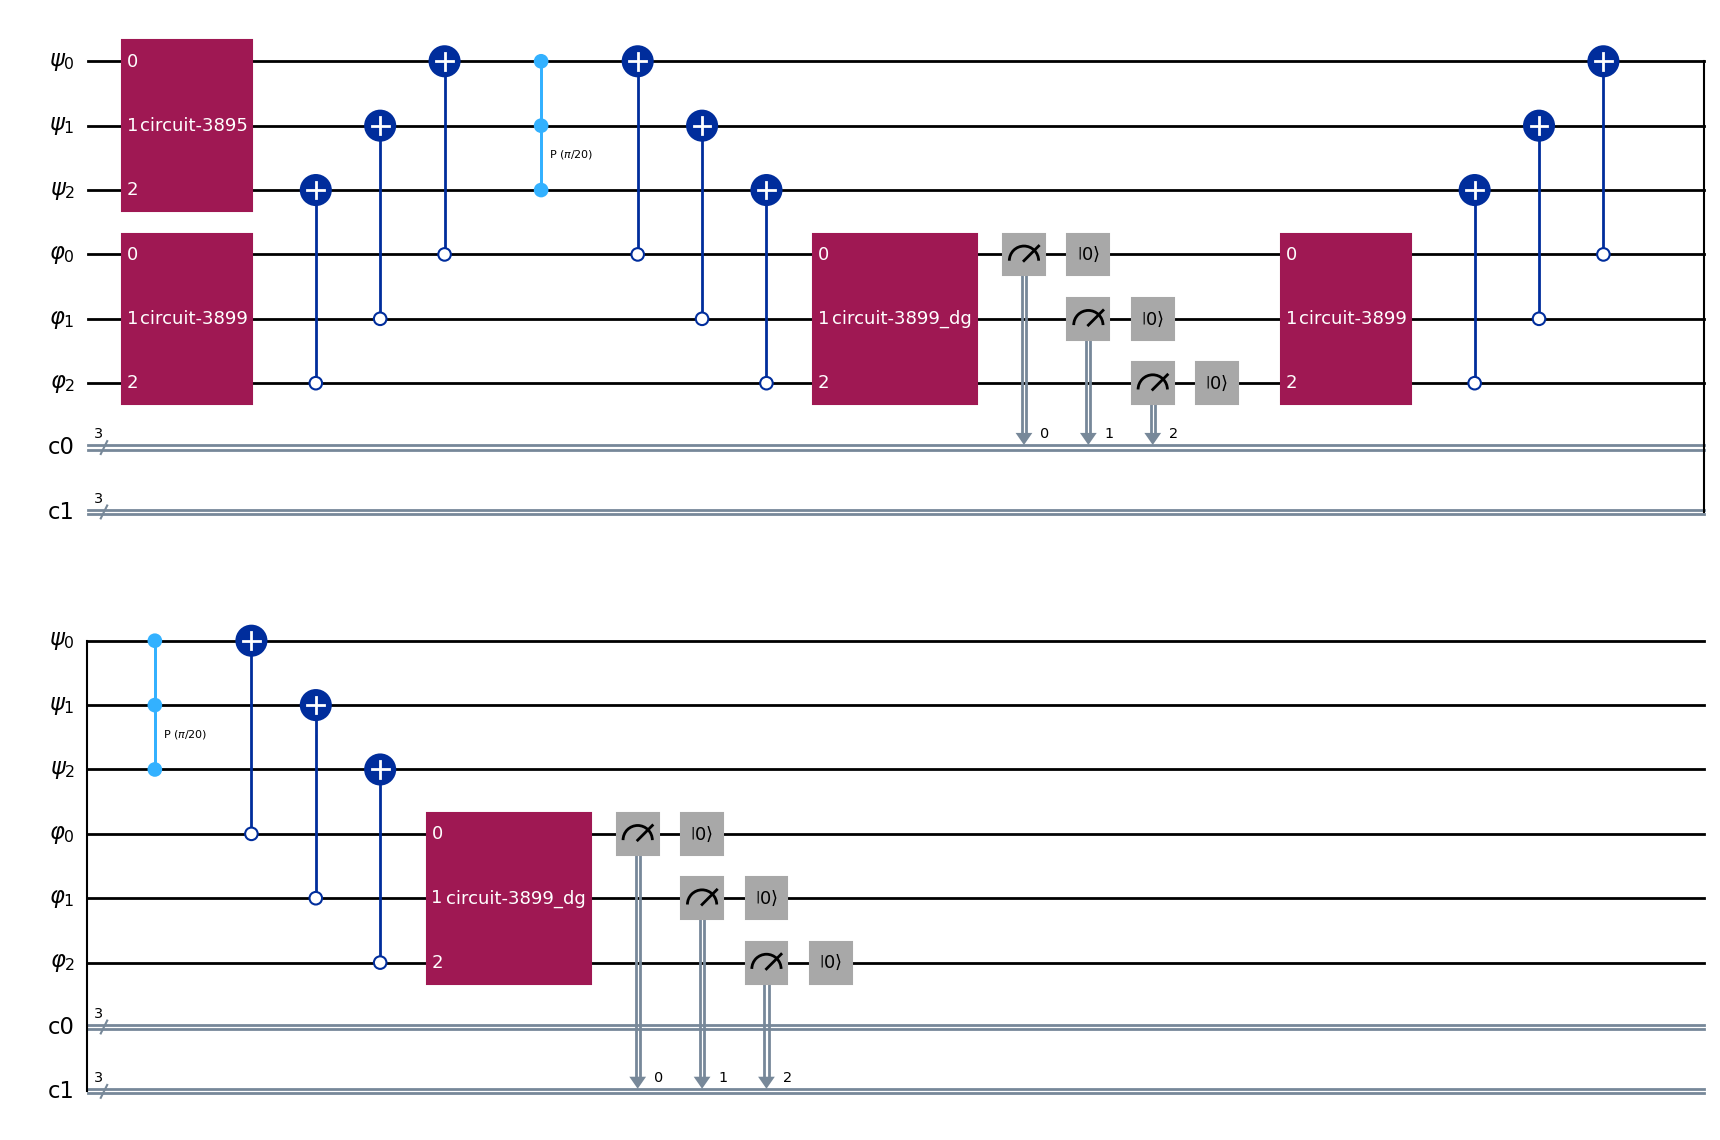

In [5]:
delta = np.pi / 20
success_fraction, all_shots, qc = success_rates(delta, m=2, shots=20)
qc.draw('mpl')

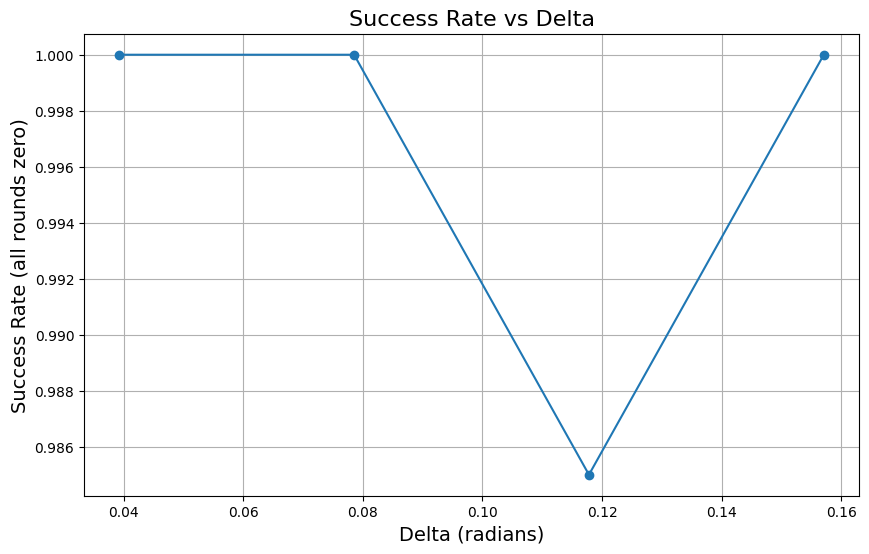

In [6]:
delta_values = [np.pi/80, np.pi/40, 3*np.pi/80, np.pi/20]
rates = [success_rates(delta, m=2, shots=200)[0] for delta in delta_values]

plt.figure(figsize=(10, 6))
plt.plot(delta_values, rates, 'o-')
plt.xlabel("Delta (radians)", fontsize=14)
plt.ylabel("Success Rate (all rounds zero)", fontsize=14)
plt.title("Success Rate vs Delta", fontsize=16)
plt.grid(True)
plt.show()

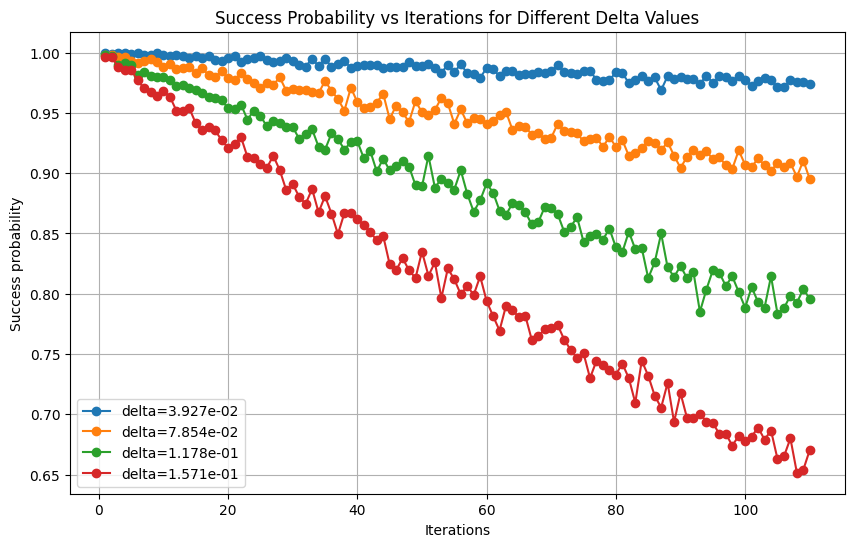

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def compare_deltas(delta_values, m, shots=2000):
    plt.figure(figsize=(10, 6))
    for delta in delta_values:
        rates = [success_rates(delta, m, shots=shots)[0] for m in m_values]
        plt.plot(m_values, rates, 'o-', label=f'delta={delta:.3e}')
    plt.xlabel('Iterations')
    plt.ylabel('Success probability')
    plt.title('Success Probability vs Iterations for Different Delta Values')
    plt.grid(True)
    plt.legend()
    plt.show()


delta_values = [np.pi/80, np.pi/40, 3*np.pi/80, np.pi/20]
m_values = list(range(1, 111))
compare_deltas(delta_values, m_values, shots=2000)
                 

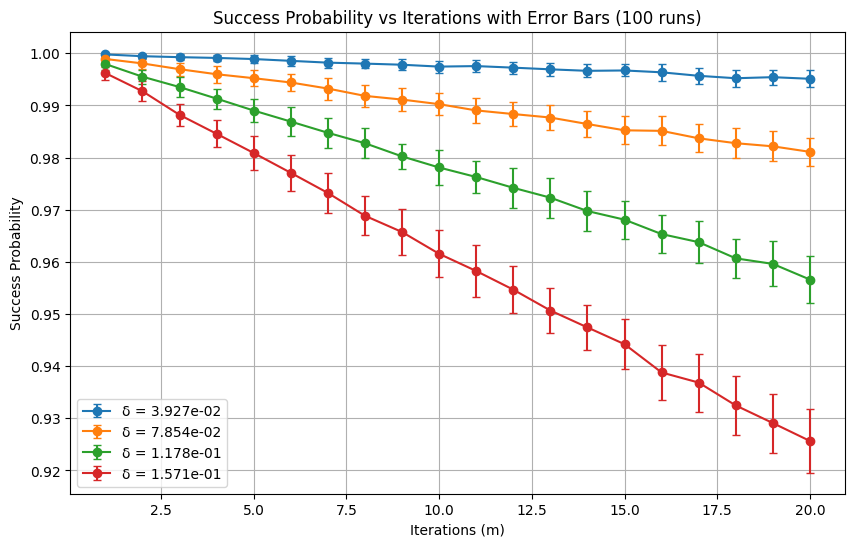

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState


# =============================
# === PARAMETERS ===
# =============================
psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 2, 3, 4, 5, 6, 7, 8]
n = 3
number_of_layers = 2
shots = 2000


# =============================
# === BUILD INITIAL STATES ===
# =============================
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()


# =============================
# === RUN ONE EXPERIMENT ===
# =============================
def run_experiment(delta, m, shots=2000):
    psi_reg = QuantumRegister(n, "ψ")
    phi_reg = QuantumRegister(n, "φ")
    cregs = [ClassicalRegister(n, name=f"c{k}") for k in range(m)]
    qc = QuantumCircuit(psi_reg, phi_reg, *cregs)

    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for k in range(m):
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, cregs[k])
        qc.reset(phi_reg)
        if k < m - 1:
            qc.append(U_phi, phi_reg)

    return qc


# =============================
# === COMPUTE SUCCESS RATE ===
# =============================
def success_rate(delta, m, shots=2000):
    qc = run_experiment(delta, m)
    sim = AerSimulator()
    qc_t = transpile(qc, sim)
    result = sim.run(qc_t, shots=shots, memory=True).result()
    memories = result.get_memory(qc_t)

    zero_state = "0" * n
    successes = sum(
        all(r == zero_state for r in mem.split(" ")) for mem in memories
    )

    return successes / shots


# =============================
# === MULTI-RUN STATISTICS ===
# =============================
def success_rate_stats(delta, m, shots=2000, repeats=100):
    """Run same configuration 'repeats' times and return mean ± std."""
    results = [success_rate(delta, m, shots=shots) for _ in range(repeats)]
    mean = np.mean(results)
    std = np.std(results)
    return mean, std


# =============================
# === COMPARE DELTAS WITH ERROR BARS ===
# =============================
def compare_deltas_with_errorbars(delta_values, m_values, shots=2000, repeats=100):
    plt.figure(figsize=(10, 6))
    for delta in delta_values:
        means, stds = [], []
        for m in m_values:
            mean, std = success_rate_stats(delta, m, shots=shots, repeats=repeats)
            means.append(mean)
            stds.append(std)
        plt.errorbar(
            m_values, means, yerr=stds, fmt='o-', capsize=3, label=f"δ = {delta:.3e}"
        )
    plt.xlabel("Iterations (m)")
    plt.ylabel("Success Probability")
    plt.title("Success Probability vs Iterations with Error Bars (100 runs)")
    plt.grid(True)
    plt.legend()
    plt.show()


# =============================
# === RUN & PLOT ===
# =============================
delta_values = [np.pi/80, np.pi/40, 3*np.pi/80, np.pi/20]
m_values = list(range(1, 21))  # limit to 20 for speed initially

compare_deltas_with_errorbars(delta_values, m_values, shots=2000, repeats=100)
